In [55]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

from plotnine import *

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.stattools import adfuller, kpss

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

from statsmodels.tsa.api import AutoReg

from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

from scipy.stats import boxcox

from statsmodels.stats.diagnostic import acorr_ljungbox



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path

from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [56]:
# Dataset: AirPassengers
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

In [57]:
# Dataset: co2
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

# TIME SERIES: URL

In [58]:
url1='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/life_expectancy_birth.csv'
url2='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/milk_production.csv'

life = pd.read_csv(url1, 
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)

milk = pd.read_csv(url2, 
                   index_col='month', 
                   parse_dates=True)



In [59]:
print(life.head(5))
print(milk.head(5))

                value
year                 
1960-01-01  69.123902
1961-01-01  69.760244
1962-01-01  69.149756
1963-01-01  69.248049
1964-01-01  70.311707
            production
month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727


# INSPECIONANDO TENDÊNCIA E SAZONALIDADE: 
    - ANÁLISE GRÁFICA

<AxesSubplot: title={'center': 'Monthly Milk Production'}, xlabel='month'>

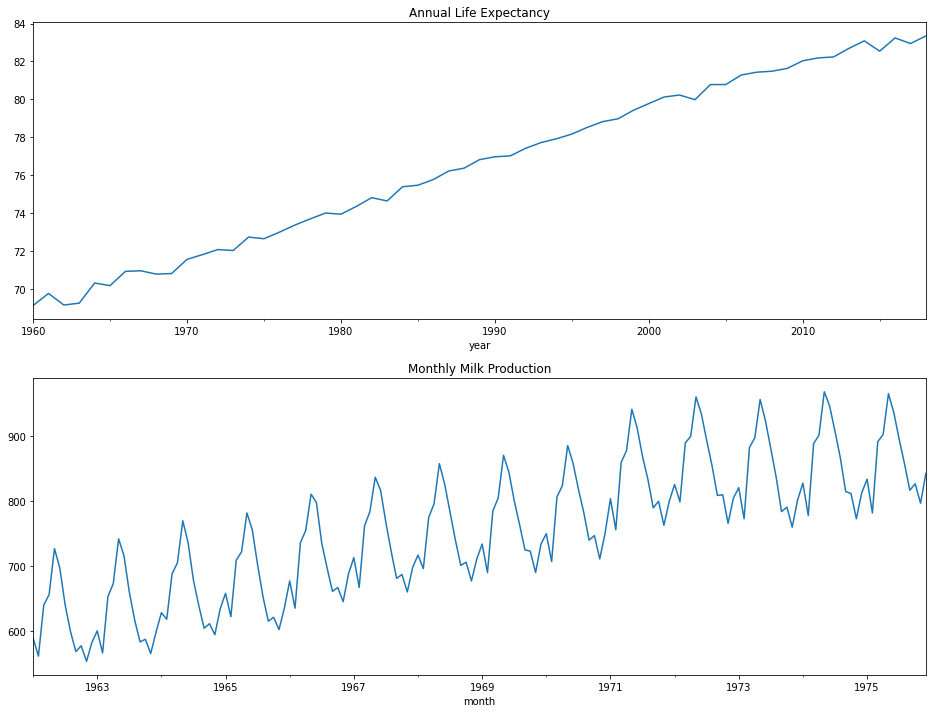

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

life.plot(title='Annual Life Expectancy', legend=False, ax=ax[0])

milk.plot(title='Monthly Milk Production', legend=False, ax=ax[1])

1. life DataFrame mostra uma tendência positiva (ascendente) e sem sazonalidade

2. milk DataFrame mostra uma tendência positiva (ascendente) e uma sazonalidade repetida (todo verão). As magnitudes sazonais e as variações ao longo do tempo parecem ser constantes, indicando uma natureza aditiva

In [61]:
# SPLIT: Função para criar train e test data set
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [62]:
test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)

life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [63]:
# Testar estacionariedade
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05: 
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [64]:
# Seleciona melhor modelo
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [65]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.
shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [66]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

# Gráficos ACF e PACF,
    - são usados para determinar as ordens (parâmetros) para alguns modelos, como o modelo ARIMA.
    - os parâmetros dos modelos AR e MA são chamados de lag orders

 1. O ACF e o PACF podem ser plotados para ajudá-lo a identificar se o processo de série temporal é um processo AR, MA ou ARMA
 2. Os gráficos PACF e ACF são referidos como correlogramas, pois os gráficos representam as estatísticas de correlação.

# Os gráficos ACF e PACF mostram valores que variam de -1 a 1 no eixo vertical (eixo y), enquanto o eixo horizontal (eixo x) indica o tamanho do atraso.  Um atraso significativo é qualquer atraso que sai do intervalo de confiança sombreado, como você verá nos gráficos. 
    - PACF para estimar a ordem AR 
    - ACF para estimar a ordem MA
    - Você precisará diferenciar a série temporal para torná-la estacionária antes de aplicar os gráficos ACF e PACF.

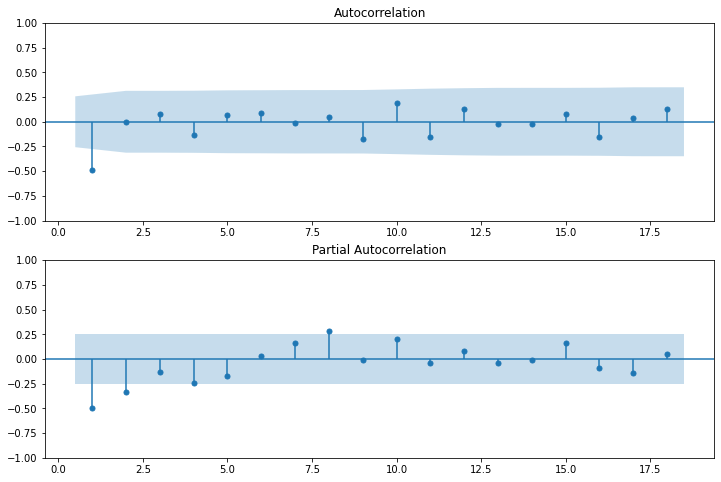

In [67]:
# Diferenciando:: removendo a tendência
life_diff = life.diff().dropna()

fig, ax = plt.subplots(2,1, figsize=(12,8))

plot_acf(life_diff, zero=False, ax=ax[0]) # zero false: remove a primeira autocorrelação que é sempre ''1''

plot_pacf(life_diff, zero=False, ax=ax[1]) # zero false: remove a primeira autocorrelação que é sempre ''1''

plt.show()


# O gráfico ACF mostra um pico significativo no atraso (ordem) 1. A significância é representada quando um atraso (linha vertical) 
# fica acima ou abaixo da área sombreada. A área sombreada representa o intervalo de confiança, que é definido como 95% por padrão. 
# No gráfico ACF, apenas o primeiro atraso é significativo, que está abaixo do intervalo de confiança inferior, e é cortado logo em seguida. 
# Todos os lags restantes não são significativos. Isso indica uma média móvel de ordem um ou MA(1).

# MA(1): significa que temos apenas uma linha vertical significativa na ACF

# O gráfico PACF mostra um decaimento gradual com oscilação. Geralmente, se PACF mostra uma queda gradual, indica um modelo de média móvel.
#  Por exemplo, se você estiver usando um modelo ARMA ou ARIMA, ele será representado como ARMA(0, 1) uma vez que os dados tenham sido 
# diferenciados para torná-los estacionários, ou ARIMA(0, 1, 1), indicando uma primeira ordem diferenciando com d=1. Tanto no ARMA quanto no ARIMA,
#  a ordem AR é p=0 e a ordem MA é q=1

In [68]:
# Para tornar esta série temporal estacionária, você deve começar com a diferenciação sazonal para remover o efeito sazonal. 
# Como as observações são feitas mensalmente, os efeitos sazonais são observados anualmente (a cada 12 meses ou período):

# 1º diferenciação
milk_diff_12 = milk.diff(12).dropna() # Removendo a sazonalidade: entre parênteses temos o período de um ciclo

check_stationarity(milk_diff_12) # TEste ADF

# A série temporal diferenciada ainda não é estacionária, então você ainda precisa realizar uma segunda diferenciação.

# 2º diferenciação
milk_diff_12_1 = milk.diff(12).diff(1).dropna()

check_stationarity(milk_diff_12_1)



'Non-Stationary	 p-value:0.16079880527711227 	 lags:12
'Stationary	 p-value:1.86542343187882e-05 	 lags:11


('Stationary', 1.86542343187882e-05)

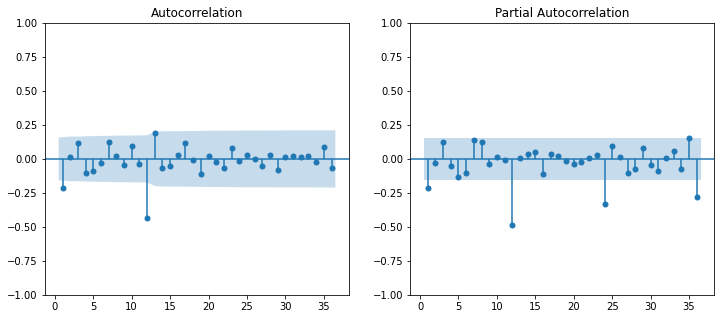

In [69]:
# Plot ADF e PACF para a série temporal estacionária
fig, ax = plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36);plt.show()

# Temos um SARIMA(0,1,1)(0,1,1,12) 

 1. Começando com o gráfico ACF, há um pico significativo no lag 1, que representa a ordem não sazonal para o processo MA como q=1.
 2. O pico no lag 12 representa a ordem sazonal para o processo MA como Q=1.
 3. No pacf um decaimento exponencial indica um processo ARMA
 4. Assim, o modelo SARIMA seria ARIMA (0, 1,1)(0, 1, 1, 12).

 Para as ordens sazonais, P e Q, você deve diagnosticar picos ou comportamentos nos atrasos s, 2s, 3s e assim por diante, onde s é o número de períodos em uma temporada.

(p,d,q)x(P,D,Q)

# Guia de exemplo para identificar as ordens AR e MA estacionárias dos gráficos PACF e ACF
    1. AR(p)
        - ACF: depois do lag p cai gradualmente. Pode ser oscilatório
        - PACF: corte no lag p

    2. MA(q)
        - ACF: corte no lag q
        - PACF: depois do lag q cai gradualmente. Pode ser oscilatório

    3. ARMA(p,q): 
        - ACF: depois do lag p cai gradualmente. Pode ser oscilatório
        - PACF: depois do lag q cai gradualmente. Pode ser oscilatório

#  Se o modelo captur todas as informações incorporadas na série temporal, você esperaria que os resíduos não tivessem autocorrelação:
    - defasagens significativas indicam a existência de alguma autocorrelação nos resíduos. 
    - Quando os resíduos apresentam autocorrelação, isso pode significar que o modelo não capturou todas as informações e há potencial para melhorias adicionais.

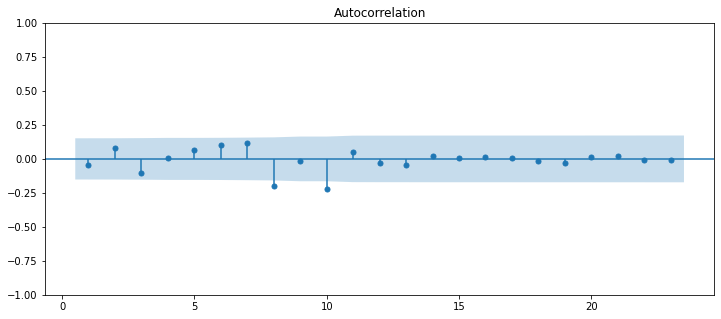

In [70]:
# Temos um SARIMA(0,1,1)(0,1,1,12) 
model = SARIMAX(milk, order=(0,1,1), seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False) # Verificando o comportamento dos resíduos
plt.show() 

# Existem autocorrelações significativas. Logo, você pode ajustar ainda mais o modelo e experimentar outros 
# valores para as ordens sazonais e não sazonais.